Layer .features.Conv2d10 Sampled 64 units from feature tensor of shape (256, 13, 13)
Layer .features.Conv2d8 Sampled 64 units from feature tensor of shape (256, 13, 13)
Layer .features.Conv2d6 Sampled 64 units from feature tensor of shape (384, 13, 13)
Layer .features.Conv2d3 Sampled 64 units from feature tensor of shape (192, 27, 27)
Gaussian Fitting center (109.2, 111.3)
 Cov mat XX 877.2 YY 839.3 XY -20.4
Gaussian Fitting center (109.8, 112.0)
 Cov mat XX 608.4 YY 596.6 XY -4.7
Gaussian Fitting center (112.3, 111.0)
 Cov mat XX 366.0 YY 361.4 XY 17.7
Gaussian Fitting center (110.7, 111.2)
 Cov mat XX 128.0 YY 133.8 XY 1.7


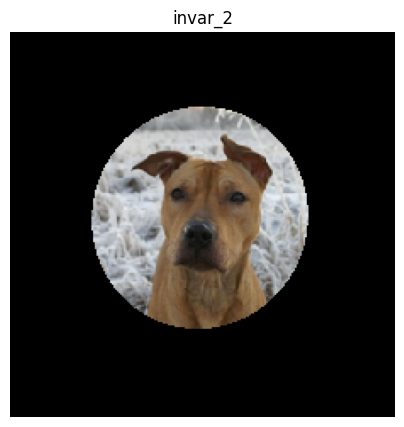

Space dimension: 4096, Population size: 40, Select size:20, Optimization Parameters:
Initial sigma: 3.000
cc=0.001, cs=0.050, c1=0.000 damps=1.050
:-------------------->  invar_2.JPEG-64-MSE-conv5432-fc6 evol finished! best score: -14.358
plot not saved
Cleanuping...
Cleanup hooks done.
Cleanup done.


In [11]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.func_lib import *
import matplotlib.pylab as plt
##
import warnings
warnings.filterwarnings("ignore") # becairfull with this

from core.utils.GAN_utils import upconvGAN
from core.utils.Optimizers import CholeskyCMAES
from core.utils.CNN_scorers import TorchScorer, resize_and_pad_tsr
#%% 
# Set parameters
refimgdir = r"C:\Data\cosine\insilico_experiments\data\tiny_set_image"

net_name = "alexnet"
layer_name = ['.features.Conv2d10', '.features.Conv2d8', '.features.Conv2d6', '.features.Conv2d3']#[".features.Conv2d10", ".features.Conv2d6"]
layer_short = "conv5432"
gan_name = "fc6"
input_size = (3, 227, 227)
img_size = (187, 187)
pading_size = (20, 20) 
popsize = 64
score_method = "MSE"

refimgnms, refimgtsr = load_ref_imgs(
        imgdir=refimgdir, preprocess_type='center_crop', image_size=227)

imgid = 2
targnm, target_imgtsr = refimgnms[imgid], refimgtsr[imgid:imgid + 1]
G = upconvGAN(gan_name).cuda()
G.requires_grad_(False)
code_length = G.codelen

scorer_random = TorchScorer(net_name)
module_names, module_types, module_spec = get_module_names(
        scorer_random.model, input_size, "cuda", False)
pop_resampling_id = 0
unit_mask_dict_random, unit_tsridx_dict_random = set_random_population_recording(
                scorer_random, layer_name, popsize=popsize, seed=pop_resampling_id)
#unit_mask_dict_random, unit_tsridx_dict_random = set_most_active_population_recording(
#                scorer_random, layer_name, target_imgtsr, pading_size, img_size, popsize=popsize)

fitdict_random = fr_estimatir(scorer_random, G, unit_tsridx_dict_random, layer_name, input_size,show_fig=False)

targ_actmat, target_imgtsr_resized = encode_image(scorer_random, target_imgtsr, key=layer_name,
                        RFresize=True, corner=pading_size, imgsize=img_size)

RF_filter = fitdict_random["fitmap"] > fitdict_random["fitmap"][int(fitdict_random["xo"]+(1.5*fitdict_random["sigma_x"])), int(fitdict_random["yo"]+(1.5*fitdict_random["sigma_y"]))]

targlabel = os.path.splitext(targnm)[0]
target_imgtsr_resized_RF_masked =\
        (torch.from_numpy(np.absolute(RF_filter[None,:,:])) / RF_filter.max()) *\
        target_imgtsr_resized

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized_RF_masked[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()


title_str = f"{targnm}-{popsize}-{score_method}-{layer_short}-{gan_name}"
#set objective function
objfunc = set_objective(score_method, targ_actmat, popul_mask=None, normalize=False)
## set optimizer
optimizer = CholeskyCMAES(code_length, population_size=None, init_sigma=3,
                init_code=np.zeros([1, code_length]), Aupdate_freq=10,
                maximize=True, random_seed=None, optim_params={})

codes_all, scores_all, actmat_all, generations, last_gem_img, last_gem_img_maske, best_imgs, best_imgs_RF_masked, best_scores, best_codes =\
        run_evol(scorer_random, objfunc, optimizer, G, reckey=layer_name, savedir=None, meta_data_df=None, trial_param_dict=None,
        titlestr =title_str, steps=100, RFresize=True, corner=pading_size, imgsize=img_size, RF_mask=RF_filter, save_plot=None)

scorer_random.cleanup()

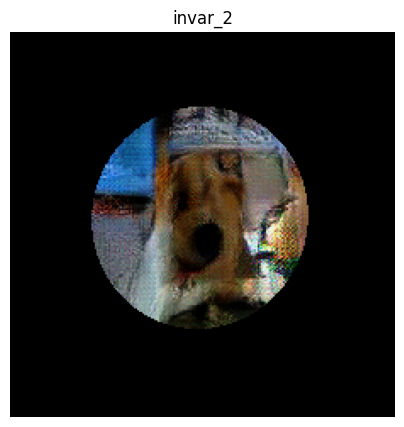

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#ax.imshow(ToPILImage()(best_imgs_RF_masked[np.argmax(best_scores)]))
ax.imshow(ToPILImage()(last_gem_img_maske.mean(dim=0)))
ax.axis("off")
ax.set_title(targlabel)
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

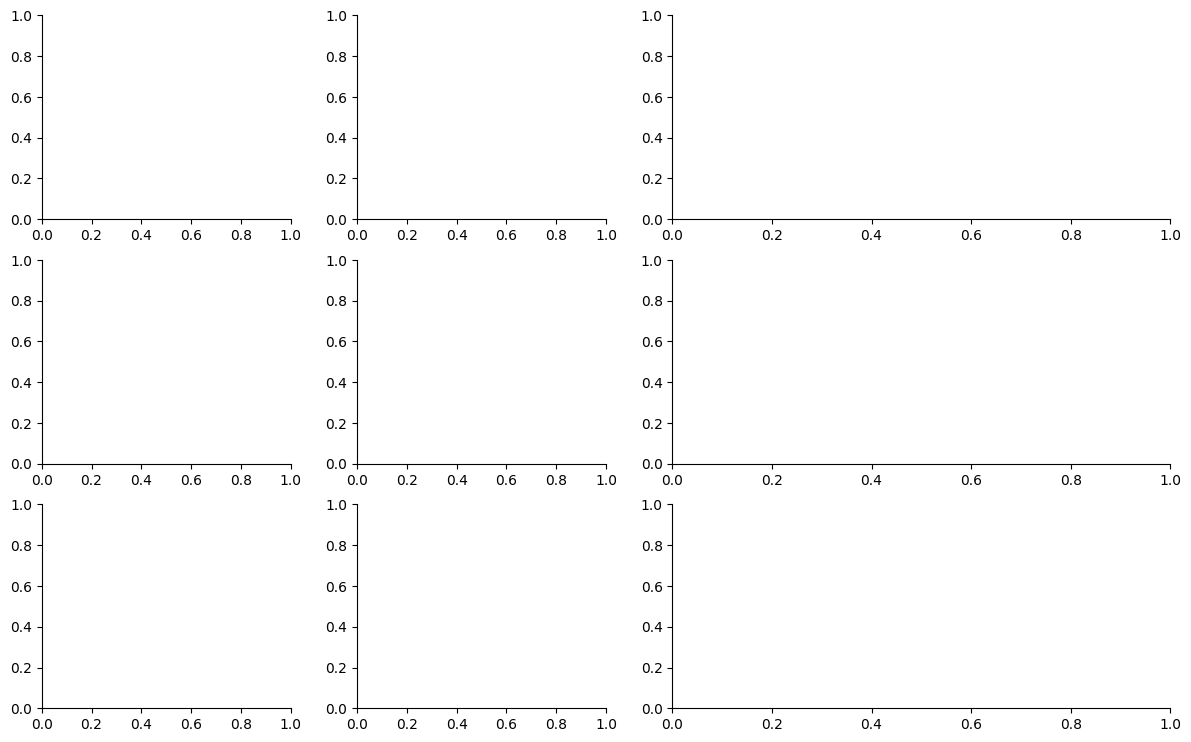

In [21]:
# prepair layout for the slide
# I want a subplot with 3 rows and 3 columns each, the columns are ratio it 1,1,2 and keep golden ratio for the figure size (wanna fit it in pover point slide)
magninication_factor = 3
# columns ratio 1,1,2
fig, ax = plt.subplots(3, 3, figsize=(magninication_factor*1.618*3, magninication_factor*3), gridspec_kw={'width_ratios': [1, 1, 2]})
# as 1,1 is target image 
ax.imshow(ToPILImage()(target_imgtsr_resized))
ax.axis("off")
plt.show()